Data used for fine-tuning and final classification :

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)
* textos_de_los_tweets_en_campaña_2016.csv

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(42)

## Setup

In [2]:
DATA_PATH=Path('./DATA/2017')
# DATA_PATH = Path('D:/Maestria/NLP/AdvacedSentimentAnalysis/database/')

WIKILM_PATH=Path('./WIKI_LM/LM')

FINETUNE_PATH=Path('./FINETUNE/2017')

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Prepare Data

In [3]:
df_1 = pd.read_csv(DATA_PATH/'train.csv', header=None)
df_2 = pd.read_csv(DATA_PATH/'general.csv', header=None)

In [4]:
tweets_1 = df_1[1].values
tweets_2 = df_2[1].values

In [5]:
len(tweets_1)

1008

In [6]:
tweets = np.concatenate([tweets_1, tweets_1, tweets_2])
del df_1, df_2, tweets_1, tweets_2

In [7]:
# tweets_samp = SortSampler(tweets, key=lambda x: len(tweets[x]))
# tweets_sampled = tweets[list(tweets_samp)]
np.random.shuffle(tweets)
tweets_sampled = tweets.copy()

In [8]:
tweets_sampled[:5]

array(['La trastienda del PP valenciano: "Las miradas de los populares valencianos se clavan en Fabra: ¿para que nos sirve?" http://t.co/m0ujeyHi',
       'Se nos ha ido el maestro Héctor Núñez. Una gran pérdida. Un sentido abrazo para la familia y el fútbol uruguayo. DEP',
       '¿Hay futuro para la socialdemocracia?  EL PAÍS comienza este debate con un texto de Sol Gallego-Díaz http://t.co/iU2HSpxu via @el_pais',
       'Google en el Congreso. http://t.co/TZh6Pdcg',
       'Laporta dice que TV3 no le da importancia suficiente al Barça.Pues menos mal,solo falta que Guardiola presente ls noticias #etfelicitofill'],
      dtype=object)

In [9]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string, i] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Remove \n
    tweets = np.array([str(i).replace('\n','') for i in tweets])
    tweets = np.array([str(i).replace('&lt;','') for i in tweets])
    tweets = np.array([str(i).replace('&gt;','') for i in tweets])
    
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'user_ref' if i.startswith('@')
               else 'hash_tag' if i.startswith('#')
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for Hashtags
#     tweets = [[['hash_tag', i] if i.startswith('#') else i for i in tweet.split()] for tweet in tweets]
#     tweets = np.array([flattern(tweet) for tweet in tweets])
#     tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string', i] if isInt(i) else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que', 'slang_string'] if i in ['q', 'k', 'qu', 'ke', 'qe'] 
               else ['por', 'slang_string'] if i=='x' 
               else ['porque', 'slang_string'] if i in ['xq', 'pq', 'porq'] 
               else ['de', 'slang_string'] if i=='d' 
               else ['te', 'slang_string'] if i=='t'
               else ['también', 'slang_string'] if i=='tb'
               else ['Que', 'slang_string'] if i in ['Q', 'K', 'Qu','Ke', 'Qe'] 
               else ['Por', 'slang_string'] if i=='X'
               else ['Porque', 'slang_string'] if i in ['Xq', 'Pq', 'Porq'] 
               else ['De', 'slang_string'] if i=='D' 
               else ['Te', 'slang_string'] if i=='T'
               else ['También', 'slang_string'] if i=='Tb'
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju'),
               ('risa_ja','aj'), ('risa_ji','ij'), ('risa_ju', 'uj')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

   
    
    return tweets



In [10]:
tweets_sampled = preprocess_tweets(tweets_sampled)

In [11]:
tweets_sampled[:5]

array(['La trastienda del PP valenciano: "Las miradas de los populares valencianos se clavan en Fabra: ¿para que nos sirve?" hyp_link',
       'Se nos ha ido el maestro Héctor Núñez. Una gran pérdida. Un sentido abrazo para la familia y el fútbol uruguayo. DEP',
       '¿Hay futuro para la socialdemocracia? EL PAÍS comienza este debate con un texto de Sol Gallego-Díaz hyp_link via user_ref',
       'Google en el Congreso. hyp_link',
       'Laporta dice que TV3 no le da importancia suficiente al Barça.Pues menos mal,solo falta que Guardiola presente ls noticias hash_tag'],
      dtype='<U234')

In [12]:
train_limit = int(len(tweets_sampled)*0.9)

In [13]:
col_names = ['label', 'tweet']
df_trn = pd.DataFrame({'tweet':tweets_sampled[:train_limit], 'label':[0]*len(tweets_sampled[:train_limit])},
                      columns=col_names)

df_val = pd.DataFrame({'tweet':tweets_sampled[train_limit:], 'label':[0]*len(tweets_sampled[train_limit:])},
                      columns=col_names)

In [14]:
df_trn.to_csv(FINETUNE_PATH/'train.csv', header=False, index=False)
df_val.to_csv(FINETUNE_PATH/'validation.csv', header=False, index=False)

## Tokenize and Standarize General Tokens


In [15]:
chunksize=24000

re1 = re.compile(r'  +')

In [16]:
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [17]:
df_trn = pd.read_csv(FINETUNE_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(FINETUNE_PATH/'validation.csv', header=None, chunksize=chunksize)

In [18]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [19]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(8310, 8310, 924, 924)

In [20]:
print(tok_trn[:2])

[['\n', 'xbos', 'la', 'trastienda', 'del', 'pp', 'valenciano', ':', '"', 'las', 'miradas', 'de', 'los', 'populares', 'valencianos', 'se', 'clavan', 'en', 'fabra', ':', '¿', 'para', 'que', 'nos', 'sirve', '?', '"', 'hyp_link'], ['\n', 'xbos', 'se', 'nos', 'ha', 'ido', 'el', 'maestro', 'héctor', 'núñez', '.', 'una', 'gran', 'pérdida', '.', 'un', 'sentido', 'abrazo', 'para', 'la', 'familia', 'y', 'el', 'fútbol', 'uruguayo', '.', 't_up', 'dep']]


In [21]:
(FINETUNE_PATH/'tmp').mkdir(exist_ok=True)

In [22]:
np.save(FINETUNE_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(FINETUNE_PATH/'tmp'/'tok_val.npy', tok_val)

In [23]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 8310),
 ('xbos', 8310),
 ('de', 6231),
 ('user_ref', 4603),
 ('.', 4594),
 ('la', 3856),
 (',', 3740),
 ('que', 3543),
 ('el', 3523),
 ('en', 3243),
 ('a', 3144),
 ('y', 2932),
 ('!', 2588),
 ('hyp_link', 2344),
 ('"', 1747),
 ('no', 1711),
 ('hash_tag', 1678),
 ('t_up', 1531),
 ('los', 1461),
 (':', 1365)]

In [24]:
max_vocab = 60000
min_freq = 1

In [25]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

8153

In [26]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [27]:
np.save(FINETUNE_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(FINETUNE_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(FINETUNE_PATH/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [28]:
BACKBONE_MODEL = WIKILM_PATH/'models/lm1_weights.h5'

In [29]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [30]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [31]:
itos2 = pickle.load((WIKILM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [32]:
em_sz,nh,nl = 400,1150,3

In [33]:
trn_lm = np.load(FINETUNE_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(FINETUNE_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(FINETUNE_PATH/'tmp'/'itos.pkl', 'rb'))

In [34]:
vs=len(itos)
vs,len(trn_lm)

(8153, 8310)

In [35]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [36]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [50]:
wd=1e-7
bptt=70
bs=64
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [51]:
trn_lm = np.load(FINETUNE_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(FINETUNE_PATH/'tmp'/'val_ids.npy')
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [52]:
itos = pickle.load(open(FINETUNE_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)
md = LanguageModelData(FINETUNE_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [53]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [54]:
learn = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [55]:
learn.model.load_state_dict(wgts)

In [56]:
learn.load('lm1_wgts')

In [57]:
# %debug
learn.lr_find2(start_lr=1e-1,end_lr=5e-1, num_it=300)

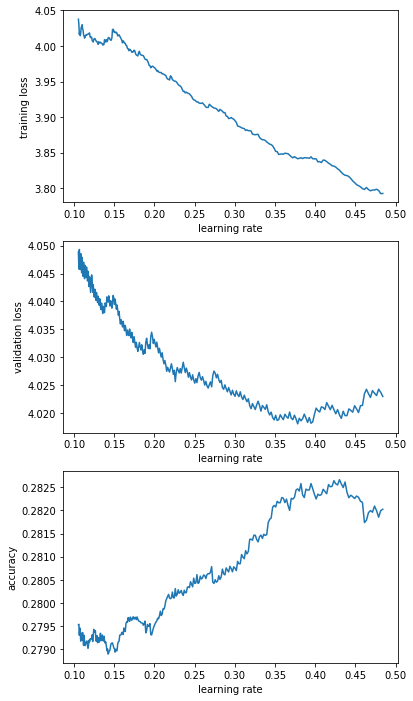

In [58]:
learn.sched.plot()

In [59]:
lr= 40e-2
lrs = lr

In [60]:
learn.clip=0.12

In [61]:
learn.fit(lr, 20, cycle_len=2, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy   
    0      3.96037    4.01272    0.283622  
    1      3.944815   4.01443    0.282489  
    2      3.929259   4.012961   0.284043  
    3      3.910282   4.040507   0.280843  
    4      3.914573   4.008591   0.283084  
    5      3.882327   4.027686   0.282088  
    6      3.868805   4.015423   0.283521  
    7      3.8551     4.009248   0.283899  
    8      3.843472   4.014245   0.28381   
    9      3.82573    4.007155   0.285005  
    10     3.821357   4.009439   0.284103  
    11     3.799497   4.006048   0.284403  
    12     3.797626   4.008744   0.284715  
    13     3.781129   4.011132   0.284168  
    14     3.768115   4.004916   0.284292  
    15     3.753981   4.000347   0.286411  
    16     3.74067    4.005304   0.286258  
    17     3.720478   4.002131   0.286137  
    18     3.721056   3.999495   0.287083  
    19     3.71861    4.003762   0.286975  
    20     3.714053   3.996337   0.289163  
    21     3.687343   4.004662 

[array([4.01013]), 0.28939075630252103]

In [62]:
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')